## Set up Google Colab environment

In [1]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    ## Specify a directory in Google Drive
    dir = '/content/drive/My Drive/Colab Notebooks/Keras_MNIST'
    os.chdir(dir)
    #os.getcwd()
    #os.listdir()

    ## Check the uptime. (Google Colab reboots every 12 hours)
    !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
    ## Check the GPU info
    !nvidia-smi
    ## Check the Python version
    !python --version

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Uptime is 0.0975111 hours (351.04 sec)
Tue Jan 29 12:28:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               


## Import modules

In [2]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

## Set up resumable logging feature

In [0]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

class LogFileProcessing():
    def __init__(self, resume_if_possible = True, log_file_path = 'training_log.csv', verbose = 1):
        self.log_file_path = log_file_path
        self.verbose = verbose
        self.update()
        if not resume_if_possible:
            self.clean_up()
            self.update()
    def update(self):
        log_file_path = self.log_file_path
        log_file_list = glob.glob(log_file_path)
        log_file_list.sort()
        self.log_file_list = log_file_list
        if self.verbose >= 2:
            print('Log file:', log_file_list)
        log_file_exists = len(log_file_list) >= 1
        self.log_file_exists = log_file_exists
    def truncate(self, epoch_from_model_file):
        log_file_path = self.log_file_path
        self.update()
        ## Remove rows after the epoch of the latest saved model 
        ## (needed because save_best_only option of checkpoint is set to True.)
        epoch_from_log_file = int(self.get_column_value('epoch'))
        epoch_diff = epoch_from_log_file - epoch_from_model_file 
        with open(log_file_path, 'r') as f:
            lines = f.readlines()
        if self.verbose >= 3:
            print('Log file contents read:', lines)
        lines_truncated = lines[:-(epoch_diff + 1)]
        with open(log_file_path, 'w') as f:
            f.writelines(lines_truncated)
        if self.verbose >= 3:
            print('New log file contents', lines_truncated)
    def clean_up(self):
        self.update()
        if self.log_file_exists:
            for f in self.log_file_list:
                os.remove(f)
            self.update()
    def get_df(self, dtype=None):
        self.update()
        if self.log_file_exists:
            try:
                return pd.read_csv(self.log_file_path, dtype=dtype)
            except:
                pass
        if self.verbose >= 2:
            print('Log file was not read as a DataFrame.')
        return None
    def get_column_value(self, column, default = '0'):
        log_df = self.get_df(dtype=str)
        if log_df is not None:
            if log_df.shape[0] >= 1:
                column_value = log_df.iloc[-1][column]
                return column_value
        if self.verbose >= 2:
            print('{} assumed to be {}.'.format(column, default))
        column_value = default
        return column_value    
    def plot_log(self, show_table = True):
        log_all_df = self.get_df()
        if log_all_df is not None:
            model_id_list = log_all_df['_Model_id'].unique()
            print('Model id list: ', model_id_list)
            for model_id in model_id_list: 
                print('### Model id: ', model_id)
                log_df = log_all_df.query('_Model_id == "{}"'.format(model_id))
                if show_table:
                    display(log_df)
                log_df.set_index('epoch')[['acc', 'val_acc']].plot(style='.-', title='Accuracy vs Epoch')
                plt.show()
                log_df.set_index('epoch')[['loss', 'val_loss']].plot(style='.-', title='Loss vs Epoch')
                plt.show()
                log_df.set_index('epoch')[['Comp_time', 'Cum_comp_time']].plot(style='.-', title='Computation Time (sec) vs Epoch')
                plt.show()          
            
class ModelFileProcessing():
    def __init__(self, model_id = '', model_file_prefix = 'model', model_file_suffix = '.hdf5', verbose = 1):
        model_file_prefix = model_file_prefix + model_id + '_epoch'
        self.model_file_prefix = model_file_prefix
        self.model_file_suffix = model_file_suffix
        self.verbose = verbose
        model_file_path = model_file_prefix + '{epoch:06d}' + model_file_suffix
        self.model_file_path = model_file_path
        self.update()
    def update(self):
        model_file_prefix = self.model_file_prefix
        model_file_suffix = self.model_file_suffix
        model_file_list = glob.glob(model_file_prefix + '*' + model_file_suffix)
        model_file_list.sort()
        if self.verbose >= 2:
            print('Model files: ', model_file_list)
        self.model_file_list = model_file_list
        model_file_exists = len(model_file_list) >= 1
        self.model_file_exists = model_file_exists

        latest_model_file = model_file_list[-1] if model_file_exists else None
        self.latest_model_file = latest_model_file

        latest_epoch = int(latest_model_file[len(model_file_prefix):-len(model_file_suffix)]) \
            if model_file_exists else 0
        self.latest_epoch = latest_epoch

        multiple_model_files_exist = len(model_file_list) >= 2
        self.multiple_model_files_exist = multiple_model_files_exist
    def clean_up_old(self):
        self.update()
        ## Delete all model files excpet the latest to save space
        if self.multiple_model_files_exist:
            for f in self.model_file_list[:-1]:
                os.remove(f)  
    def clean_up_all(self):
        self.update()
        ## Delete all model files if they exist.
        if self.model_file_exists:
            for f in self.model_file_list:
                os.remove(f)   
                
class ModelParams(keras.callbacks.Callback):
    def __init__(self, model_param_dict = {}, verbose = 2):
        self.model_param_dict = model_param_dict
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}):
        if self.verbose >= 3:
            print('Model params: ', self.model_param_dict)
        ## Add the model parameters to the logs
        logs.update(self.model_param_dict)
        if self.verbose >= 3:
            print('logs: ', logs)
        
class OldModelFileCleanup(keras.callbacks.Callback):
    def __init__(self, mfp):
        self.mfp = mfp
    def on_epoch_end(self, epoch, logs={}):     
        self.mfp.clean_up_old()
        
import time          
class CompTime(keras.callbacks.Callback):
    def __init__(self, lfp):
        self.lfp = lfp
        self.verbose = lfp.verbose
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        ## Calculate computation time for the epoch
        comp_time = time.time() - self.epoch_time_start
        logs['Comp_time'] = comp_time
        if self.verbose >= 2:
            print('Computation time: {} sec'.format(comp_time))
        ## Calculate cumulative computation time up to the epoch
        cum_comp_time_past = \
        float(self.lfp.get_column_value('Cum_comp_time')) if epoch >= 1 else 0
        logs['Cum_comp_time'] = cum_comp_time_past + comp_time
          
def setup_model_and_callbacks(lfp, create_model, input_shape, resume_if_possible = True,
                             model_param_dict = {}, verbose = 1):
    
    mfp = ModelFileProcessing(model_id = model_param_dict['_Model_id'], verbose = 1)
    resume_flag = resume_if_possible and mfp.model_file_exists and lfp.log_file_exists ## To Do: if the model Id entry exists in the CSV log file.

    if resume_flag:
        ## Load the saved model
        model = keras.models.load_model(mfp.latest_model_file)
        print('Use {} to resume fitting.'.format(mfp.latest_model_file))
        initial_epoch = mfp.latest_epoch
        ## Truncate the log file
        lfp.truncate(epoch_from_model_file = mfp.latest_epoch) 

    if not resume_flag:
        ## Create a basic model instance
        model = create_model(input_shape)
        print('Model created.')
        initial_epoch = 0
        ## Delete all model files if they exist.
        mfp.clean_up_all()

    ## Create checkpoint callback
    check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = mfp.model_file_path, 
        monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'auto', 
        save_weights_only = False, period = 1)
    
    ## Create old model file cleanup callback
    old_model_file_cleanup_ = OldModelFileCleanup(mfp)
    
    ## Create computation time callback
    comp_time_ = CompTime(lfp)
    
    ## Create model params callback
    model_params_ = ModelParams(model_param_dict)

    ## Create CSV logger callback
    csv_logger_ = tf.keras.callbacks.CSVLogger(filename = lfp.log_file_path, separator=',',
                                               append = True)

    ## Create early stopping callback
    early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
        min_delta=0, patience=5, verbose=1, mode='auto', baseline=None)

    callbacks = [check_point_, old_model_file_cleanup_, 
                 model_params_, comp_time_, csv_logger_, early_stopping_]

    return model, callbacks, initial_epoch

## Set up dataset

In [4]:
dataset_name = 'MNIST_1000samples' ## logged in the log file.

if dataset_name == 'MNIST_1000samples':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    print('x_train: ', x_train.shape)
    print('y_train', y_train.shape)
    print('x_test: ', x_test.shape)
    print('y_test', y_test.shape)

    input_shape = x_train.shape[1:]
    print('input_shape: ', input_shape )

    num_classes = 10

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    ## Reduce samples size to speed up 
    n = 1000
    y_train = y_train[:n]
    y_test = y_test[:n]

    x_train = x_train[:n]
    x_test = x_test[:n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

    print('\n### data after processing')
    print('x_train: ', x_train.shape)
    print('y_train', y_train.shape)
    print('x_test: ', x_test.shape)
    print('y_test', y_test.shape)
 
    input_shape = x_train.shape[1:]
    print('input_shape: ', input_shape )

x_train:  (60000, 28, 28)
y_train (60000,)
x_test:  (10000, 28, 28)
y_test (10000,)
input_shape:  (28, 28)

### data after processing
x_train:  (1000, 28, 28, 1)
y_train (1000,)
x_test:  (1000, 28, 28, 1)
y_test (1000,)
input_shape:  (28, 28, 1)


## Set up model parameters

In [0]:
NotUsed="""
### Grid Search 
 
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adagrad, RMSprop, Adam

batch_size_list = [64]

optimizer_dict = {}
#optimizer_dict['SGD'] = SGD()
#optimizer_dict['SGD_momentum_0.5'] = SGD(momentum = 0.5)
#optimizer_dict['SGD_momentum_0.9'] = SGD(momentum = 0.9)
#optimizer_dict['SGD_momentum_0.99'] = SGD(momentum = 0.99)         
#optimizer_dict['Adagrad'] = Adagrad()
#optimizer_dict['RMSprop'] = RMSprop()
optimizer_dict['Adam'] = Adam()

activation_list = []
activation_list.append('relu')
#activation_list.append('sigmoid')
#activation_list.append('elu')

objective_list = []
objective_list.append('sparse_categorical_crossentropy')
#objective_list.append('categorical_crossentropy')

dropout_rate_list = [0.0, 0.5]

model_param_dict_list = []
i = 0
for batch_size in batch_size_list:
    for optimizer, _ in optimizer_dict.items():
        for activation in activation_list:
            for objective in objective_list:
                for dropout_rate in dropout_rate_list:
                    d = {}
                    d['_Dataset_name'] = dataset_name
                    d['_Model_setup'] = 'Dense_Only'
                    d['_Model_id'] = '{:06d}'.format(i)
                    d['Batch_size'] = batch_size
                    d['Optimizer'] = optimizer
                    d['Acivation'] = activation
                    d['Objective'] = objective
                    d['Dropout_rate'] = dropout_rate
                    i += 1
                    print(d)
                    model_param_dict_list.append(d)
"""

In [6]:
### derivative style 

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D
from keras.optimizers import SGD, Adagrad, RMSprop, Adam, Adadelta

batch_size_list = [64]

optimizer_dict = {}
optimizer_dict['SGD'] = SGD()
optimizer_dict['SGD_momentum_0.5'] = SGD(momentum = 0.5)
optimizer_dict['SGD_momentum_0.9'] = SGD(momentum = 0.9)
optimizer_dict['SGD_momentum_0.99'] = SGD(momentum = 0.99)         
optimizer_dict['Adagrad'] = Adagrad()
optimizer_dict['RMSprop'] = RMSprop()
optimizer_dict['Adadelta'] = Adadelta()

optimizer_dict['Adam'] = Adam(lr=0.001)
optimizer_dict['Adam_lr0.0001'] = Adam(lr=0.0001)
optimizer_dict['Adam_lr0.01'] = Adam(lr=0.01)

objective_list = []
objective_list.append('sparse_categorical_crossentropy')
#objective_list.append('categorical_crossentropy')

dropout_rate_list = [0.0, 0.5]

base_model_param_dict = {'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
derivative_dict_list = \
[{'Batch_size': 32},
 {'Batch_size': 128},
 {'Batch_size': 256},
 {'Acivation': 'sigmoid'}, 
 {'Acivation': 'elu'},
 {'Acivation': 'tanh'},
 {'Acivation': 'selu'},
 {'Acivation': 'hard_sigmoid'},
 {'Acivation': 'linear'},
 {'Dropout_rate': 0.3},
 {'Dropout_rate': 0.5},
 {'Dropout_rate': 0.7},
 {'Dropout_rate': 0.9},
 {'Optimizer': 'Adam_lr0.0001'},
 {'Optimizer': 'Adam_lr0.01'},
 {'Optimizer': 'SGD'},
 {'Optimizer': 'SGD_momentum_0.5'},
 {'Optimizer': 'SGD_momentum_0.9'},
 {'Optimizer': 'SGD_momentum_0.99'},
 {'Optimizer': 'RMSprop'},
 {'Optimizer': 'Adagrad'},
 {'Optimizer': 'Adadelta'}]

model_param_dict_list = [base_model_param_dict]
print(base_model_param_dict)

for i, derivative_dict in enumerate(derivative_dict_list, 1):
    model_param_dict = base_model_param_dict.copy()
    model_param_dict.update({'_Model_id': '{:06d}'.format(i)})
    model_param_dict.update(derivative_dict)
    model_param_dict_list.append(model_param_dict)
    print(model_param_dict)

Using TensorFlow backend.


{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000001', 'Batch_size': 32, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000002', 'Batch_size': 128, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000003', 'Batch_size': 256, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000004', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'sigm

## Train models

In [7]:
## Set resume_if_possible = True to resume using a model file if available.
## Set resume_if_possible = False to force fitting from scratch.
#resume_if_possible = True
resume_if_possible = False

epochs = 10

lfp = LogFileProcessing(resume_if_possible = resume_if_possible, verbose = 1)

initial_model_id_num = int(lfp.get_column_value('_Model_id'))

for model_param_dict in model_param_dict_list[initial_model_id_num:]:
    print(model_param_dict)
    ## Assign variables as in the model_param_dict dictionary
    globals().update(model_param_dict) 
    
    if _Model_setup == 'Dense_Only':
        def create_model(input_shape):
            model = Sequential()
            model.add(Flatten(input_shape = input_shape))
            model.add(Dense(512, activation = Acivation))
            model.add(Dropout(Dropout_rate))
            model.add(Dense(10, activation='softmax'))
            model.compile(optimizer = optimizer_dict[Optimizer], 
                          loss=Objective, metrics=['accuracy'])
            return model
    if _Model_setup == 'CNN': 
        def create_model(input_shape):
            model = Sequential()
            model.add(Conv2D(512, kernel_size = (3, 3), strides = (1, 1),
                           activation = Acivation, input_shape = input_shape))
            model.add(Flatten())
            model.add(Dropout(Dropout_rate))
            model.add(Dense(10, activation='softmax'))
            model.compile(optimizer = optimizer_dict[Optimizer], 
                        loss=Objective, metrics=['accuracy'])
            return model
  
    model, callbacks, initial_epoch = \
    setup_model_and_callbacks(lfp, create_model, input_shape, 
                              resume_if_possible = resume_if_possible,
                              model_param_dict = model_param_dict, verbose = 1)

    model.summary()

    ## Fit 
    model.fit(x_train, y_train, validation_data = (x_test, y_test), shuffle = True,
              batch_size = Batch_size, epochs = epochs, callbacks = callbacks, 
              initial_epoch = initial_epoch)

{'_Dataset_name': 'MNIST_1000samples', '_Model_setup': 'CNN', '_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
Model created.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 512)       5120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 346112)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 346112)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3461130   
Total params: 3,466,250
Trainable params: 3,466,250
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 

Model id list:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
### Model id:  0


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
0,0,relu,64,4.859516,4.859516,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.678,1.073819,0.816,0.556902
1,1,relu,64,0.784239,5.643754,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.902,0.299509,0.854,0.447883
2,2,relu,64,0.631169,6.274923,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.959,0.154473,0.853,0.412687
3,3,relu,64,0.779340,7.054263,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.986,0.071465,0.866,0.455186
4,4,relu,64,0.779954,7.834218,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.997,0.031073,0.871,0.429855
5,5,relu,64,0.785019,8.619237,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,0.999,0.010245,0.877,0.416064
6,6,relu,64,0.795396,9.414633,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.005822,0.881,0.445837
7,7,relu,64,0.790236,10.204869,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.003772,0.883,0.453763
8,8,relu,64,0.630830,10.835698,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.002729,0.883,0.468772
9,9,relu,64,0.623005,11.458704,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,0,CNN,1.000,0.002108,0.883,0.475686


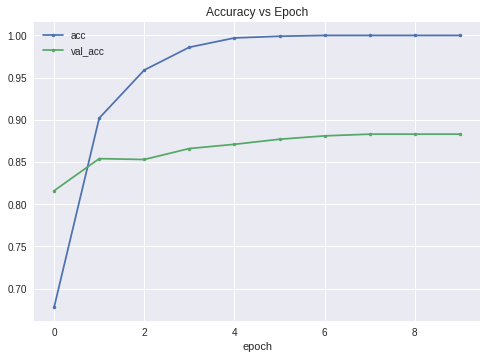

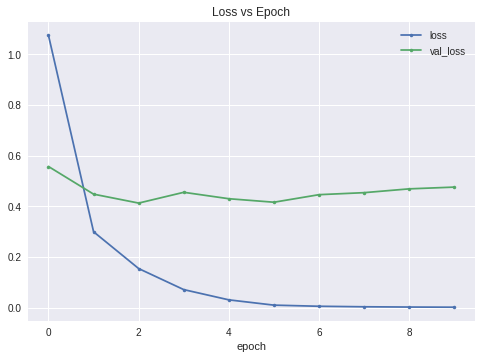

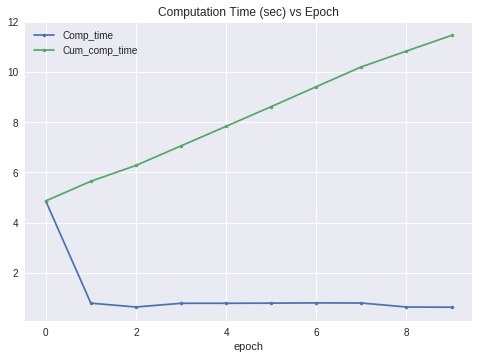

### Model id:  1


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
10,0,relu,32,1.474946,1.474946,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,0.762,0.730819,0.849,0.456049
11,1,relu,32,1.122735,2.597681,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,0.962,0.127193,0.882,0.354257
12,2,relu,32,1.064852,3.662532,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,0.994,0.027423,0.895,0.370034
13,3,relu,32,1.066854,4.729386,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.005618,0.901,0.377900
14,4,relu,32,0.908812,5.638199,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.002161,0.900,0.385972
15,5,relu,32,1.061516,6.699715,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.001094,0.902,0.399654
16,6,relu,32,0.903673,7.603387,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.000785,0.901,0.413004
17,7,relu,32,0.921687,8.525074,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.000639,0.900,0.423118
18,8,relu,32,0.915885,9.440959,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.000521,0.901,0.430114
19,9,relu,32,0.906963,10.347922,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,1,CNN,1.000,0.000448,0.902,0.436071


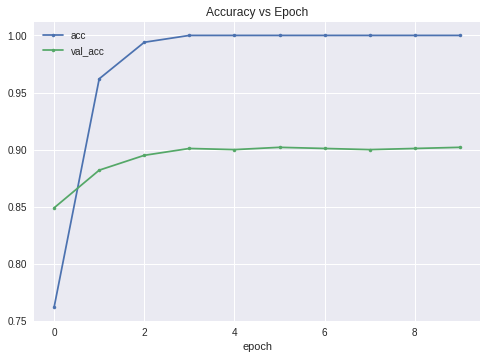

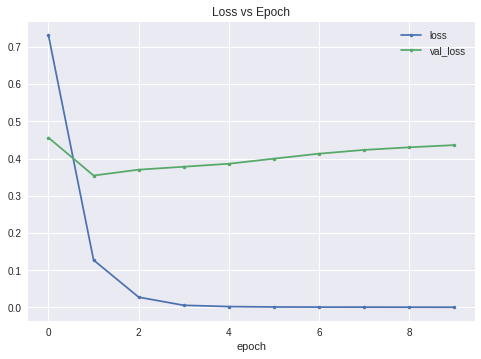

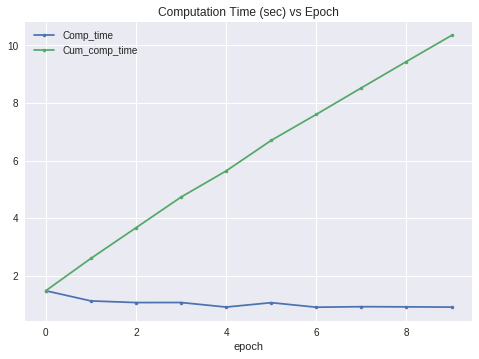

### Model id:  2


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
20,0,relu,128,1.213387,1.213387,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,0.646,1.080808,0.797,0.601885
21,1,relu,128,0.652716,1.866103,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,0.924,0.265057,0.866,0.434573
22,2,relu,128,0.680006,2.546109,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,0.971,0.091127,0.889,0.394459
23,3,relu,128,0.666636,3.212745,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,0.995,0.031676,0.890,0.377961
24,4,relu,128,0.496245,3.708990,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.007091,0.887,0.429302
25,5,relu,128,0.499580,4.208570,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.001586,0.890,0.474783
26,6,relu,128,0.657337,4.865907,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.000767,0.892,0.505638
27,7,relu,128,0.502080,5.367987,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.000503,0.890,0.518572
28,8,relu,128,0.500917,5.868904,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.000384,0.890,0.523258
29,9,relu,128,0.498127,6.367031,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,2,CNN,1.000,0.000299,0.890,0.524486


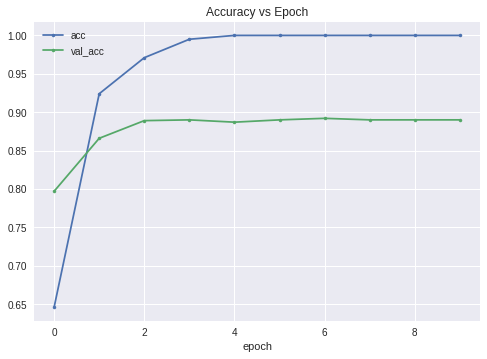

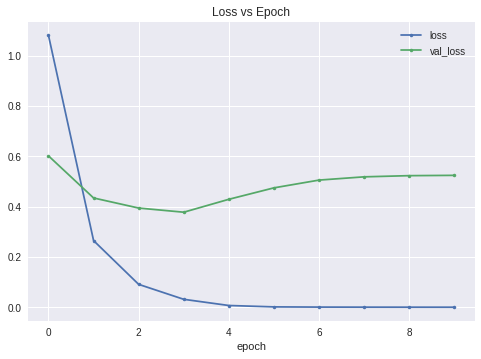

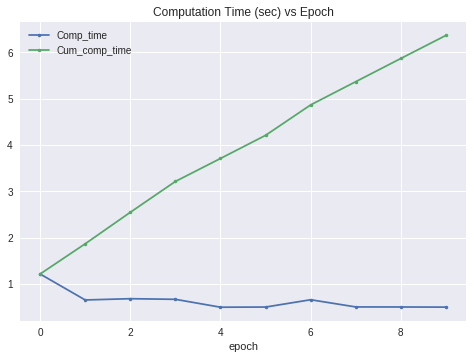

### Model id:  3


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
30,0,relu,256,1.386318,1.386318,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.469,1.547518,0.688,0.954984
31,1,relu,256,0.643879,2.030197,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.838,0.504596,0.820,0.568201
32,2,relu,256,0.624923,2.655120,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.928,0.255632,0.855,0.449891
33,3,relu,256,0.595213,3.250333,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.966,0.124767,0.904,0.347750
34,4,relu,256,0.439987,3.690320,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.990,0.052761,0.894,0.338470
35,5,relu,256,0.437683,4.128002,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,0.999,0.015771,0.883,0.383947
36,6,relu,256,0.440663,4.568666,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,1.000,0.005408,0.884,0.416052
37,7,relu,256,0.446153,5.014819,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,1.000,0.002406,0.888,0.436585
38,8,relu,256,0.442970,5.457788,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,3,CNN,1.000,0.001085,0.893,0.460232


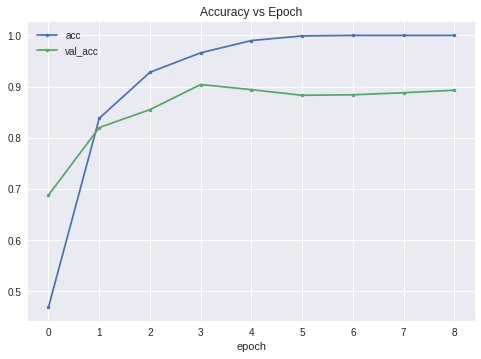

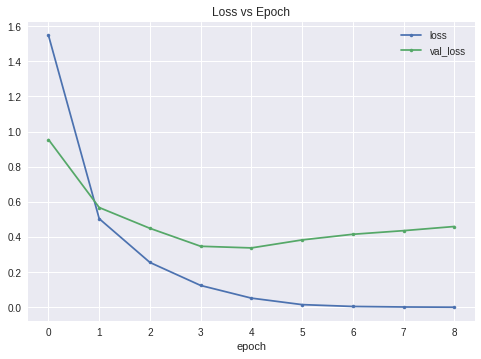

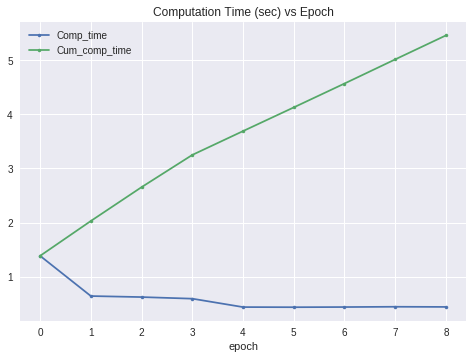

### Model id:  4


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
39,0,sigmoid,64,1.332573,1.332573,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.104,12.839013,0.11,14.345107
40,1,sigmoid,64,0.636305,1.968878,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.105,14.425697,0.11,14.345107
41,2,sigmoid,64,0.658326,2.627204,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.105,14.425697,0.11,14.345107
42,3,sigmoid,64,0.626296,3.253500,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.105,14.425697,0.11,14.345107
43,4,sigmoid,64,0.636819,3.890320,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.105,14.425697,0.11,14.345107
44,5,sigmoid,64,0.629955,4.520274,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,4,CNN,0.105,14.425697,0.11,14.345107


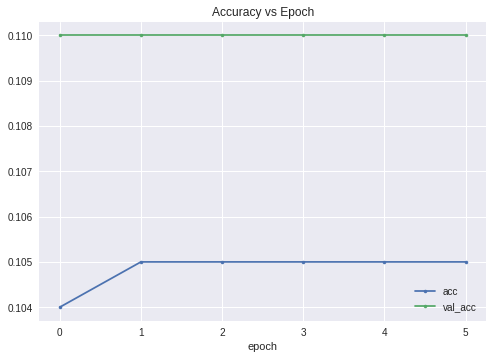

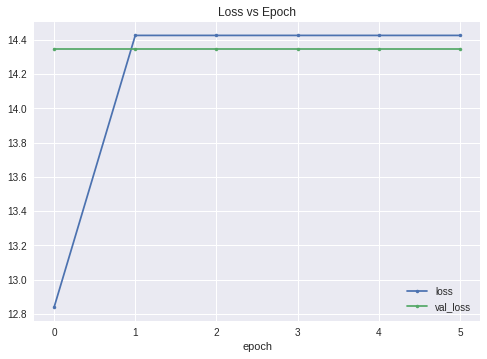

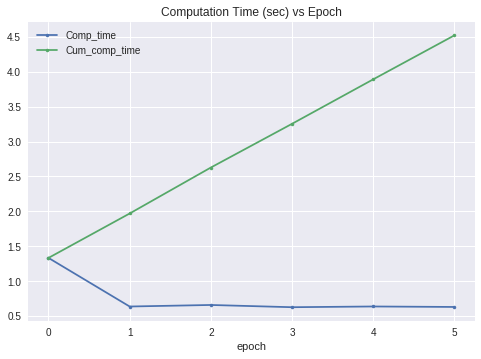

### Model id:  5


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
45,0,elu,64,1.346010,1.346010,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.642,1.518395,0.690,1.313561
46,1,elu,64,0.819300,2.165310,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.876,0.577027,0.816,0.957062
47,2,elu,64,0.659722,2.825031,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.943,0.250890,0.781,0.928370
48,3,elu,64,0.819421,3.644452,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.976,0.111997,0.824,0.855235
49,4,elu,64,0.648417,4.292869,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.990,0.060701,0.820,0.903901
50,5,elu,64,0.655769,4.948638,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.998,0.032732,0.822,0.858232
51,6,elu,64,0.836579,5.785217,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.999,0.023240,0.825,0.894869
52,7,elu,64,0.655998,6.441215,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.999,0.020022,0.825,0.911316
53,8,elu,64,0.812861,7.254076,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.999,0.019166,0.827,0.924143
54,9,elu,64,0.665679,7.919755,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,5,CNN,0.999,0.018655,0.827,0.931790


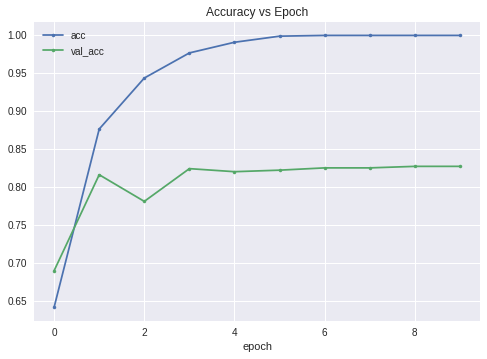

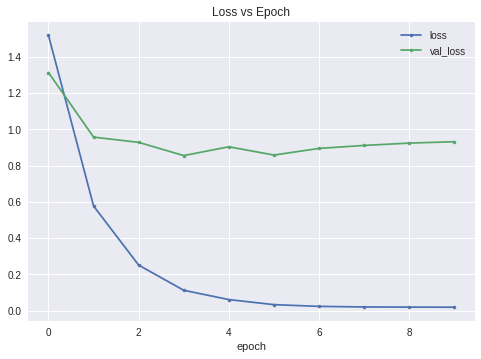

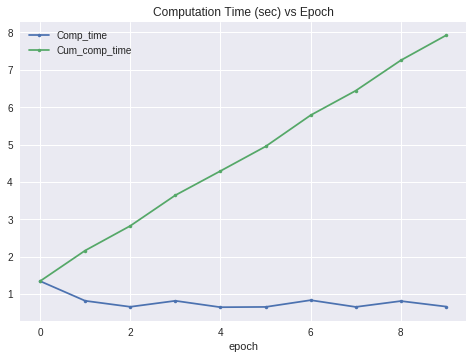

### Model id:  6


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
55,0,tanh,64,1.324980,1.324980,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.609,1.942072,0.747,1.478274
56,1,tanh,64,0.794137,2.119117,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.862,0.725095,0.791,1.200063
57,2,tanh,64,0.644154,2.763271,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.908,0.490562,0.785,1.129412
58,3,tanh,64,0.794143,3.557414,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.952,0.238039,0.807,1.013974
59,4,tanh,64,0.811927,4.369341,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.982,0.127514,0.814,0.955752
60,5,tanh,64,0.798939,5.168281,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.986,0.108811,0.823,1.052001
61,6,tanh,64,0.643904,5.812185,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.995,0.092747,0.817,0.991659
62,7,tanh,64,0.631449,6.443635,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.995,0.086362,0.819,1.031222
63,8,tanh,64,0.666167,7.109802,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.995,0.083905,0.814,1.021547
64,9,tanh,64,0.639441,7.749242,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,6,CNN,0.995,0.082880,0.817,1.023794


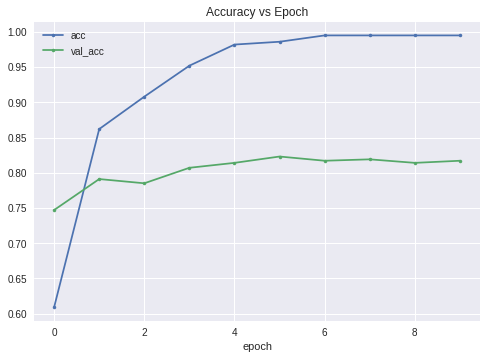

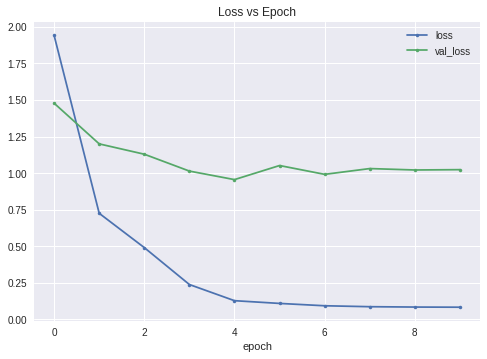

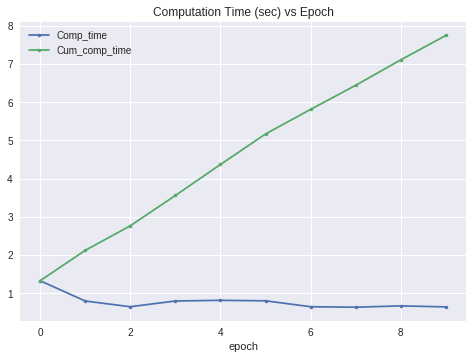

### Model id:  7


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
65,0,selu,64,1.767391,1.767391,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.619,2.341786,0.690,2.264510
66,1,selu,64,1.213853,2.981244,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.815,1.191311,0.732,2.490774
67,2,selu,64,1.193452,4.174696,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.901,0.839512,0.770,2.137756
68,3,selu,64,1.158628,5.333324,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.936,0.440706,0.822,1.566270
69,4,selu,64,1.016805,6.350129,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.967,0.255137,0.820,1.450889
70,5,selu,64,1.020955,7.371084,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.979,0.173946,0.808,1.580061
71,6,selu,64,1.004676,8.375760,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.989,0.144965,0.813,1.483799
72,7,selu,64,1.012224,9.387985,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.992,0.131497,0.816,1.488633
73,8,selu,64,1.022148,10.410133,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,7,CNN,0.992,0.129490,0.813,1.481026


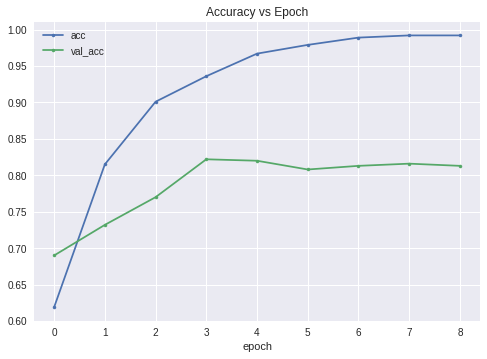

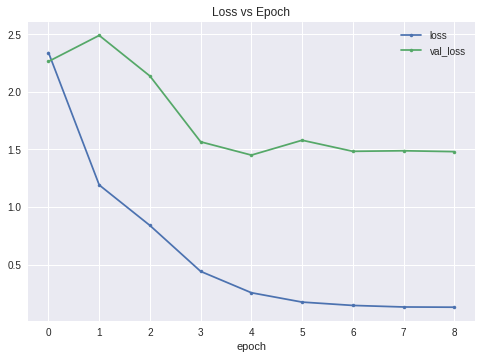

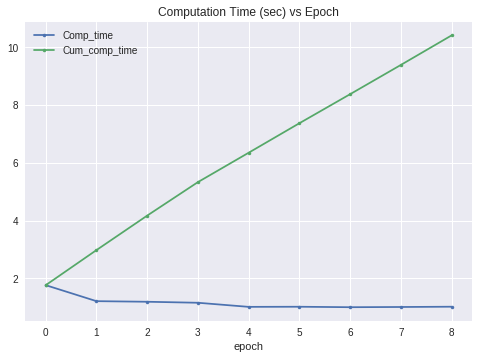

### Model id:  8


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
74,0,hard_sigmoid,64,1.764599,1.764599,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.088,13.466235,0.107,14.393459
75,1,hard_sigmoid,64,0.982089,2.746687,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.093,14.619112,0.107,14.393459
76,2,hard_sigmoid,64,0.955943,3.702630,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.093,14.619112,0.107,14.393459
77,3,hard_sigmoid,64,0.966933,4.669563,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.093,14.619112,0.107,14.393459
78,4,hard_sigmoid,64,0.968019,5.637582,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.093,14.619112,0.107,14.393459
79,5,hard_sigmoid,64,0.960699,6.598281,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,8,CNN,0.093,14.619112,0.107,14.393459


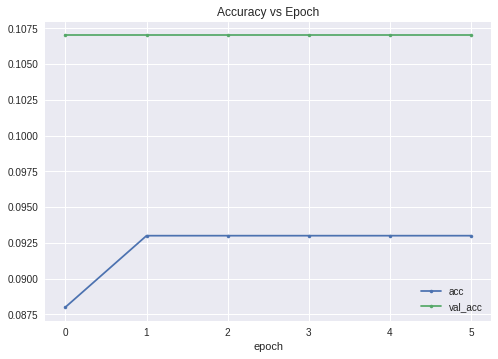

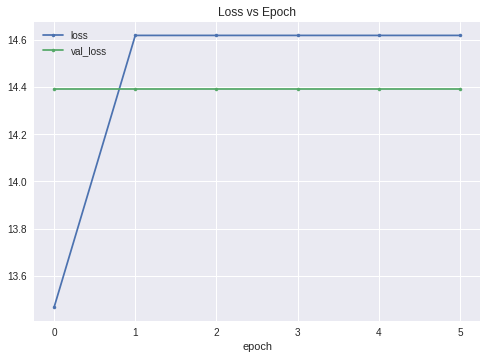

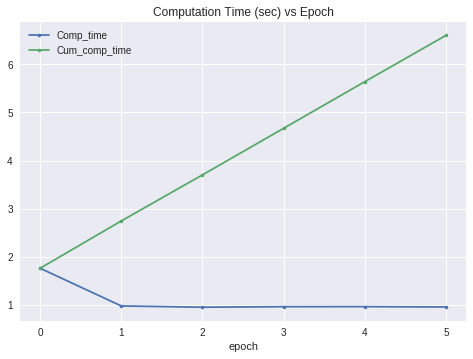

### Model id:  9


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
80,0,linear,64,1.462694,1.462694,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.622,1.985311,0.755,2.079997
81,1,linear,64,0.736444,2.199138,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.868,1.060626,0.807,1.693569
82,2,linear,64,0.565767,2.764905,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.916,0.639745,0.767,1.699509
83,3,linear,64,0.565114,3.330019,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.913,0.447220,0.791,1.419565
84,4,linear,64,0.564113,3.894132,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.959,0.238593,0.799,1.184005
85,5,linear,64,0.727644,4.621777,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.979,0.143499,0.820,1.121463
86,6,linear,64,0.733127,5.354903,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.991,0.104926,0.821,1.144655
87,7,linear,64,0.581554,5.936458,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.987,0.107144,0.816,1.146992
88,8,linear,64,0.719255,6.655713,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.990,0.100087,0.840,1.060407
89,9,linear,64,0.572099,7.227812,0.0,sparse_categorical_crossentropy,Adam,MNIST_1000samples,9,CNN,0.992,0.091419,0.833,1.065883


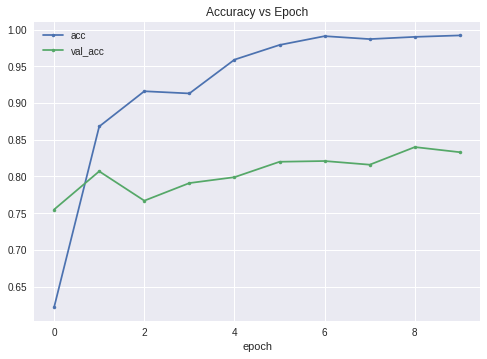

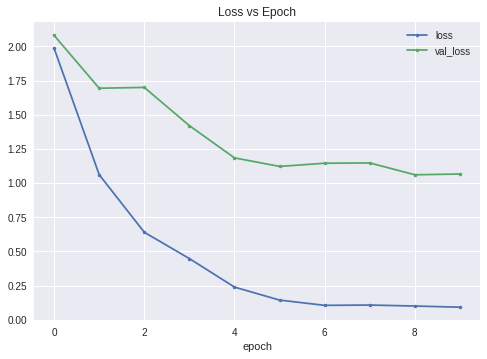

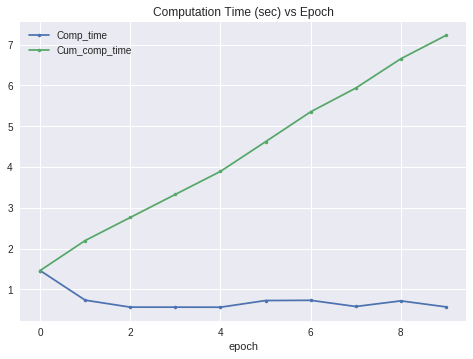

### Model id:  10


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
90,0,relu,64,1.726137,1.726137,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,0.682,1.063908,0.800,0.692970
91,1,relu,64,1.020324,2.746461,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,0.932,0.222649,0.871,0.390880
92,2,relu,64,0.983766,3.730227,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,0.988,0.062185,0.886,0.386462
93,3,relu,64,1.020986,4.751213,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,0.999,0.012257,0.896,0.367162
94,4,relu,64,0.826559,5.577772,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.003321,0.896,0.385782
95,5,relu,64,0.824257,6.402029,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.001491,0.896,0.397910
96,6,relu,64,0.985233,7.387263,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.000880,0.897,0.402164
97,7,relu,64,0.995293,8.382556,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.000702,0.899,0.411080
98,8,relu,64,0.821737,9.204293,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.000588,0.899,0.416502
99,9,relu,64,0.980862,10.185155,0.3,sparse_categorical_crossentropy,Adam,MNIST_1000samples,10,CNN,1.000,0.000519,0.901,0.419097


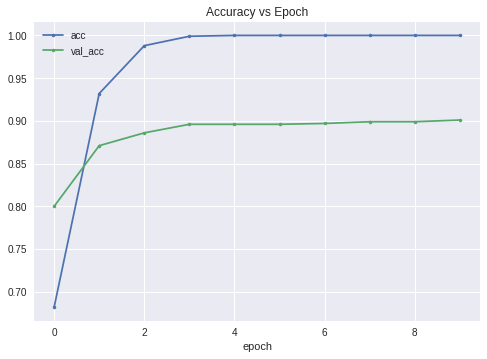

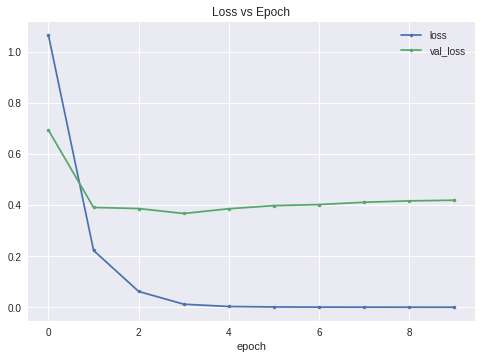

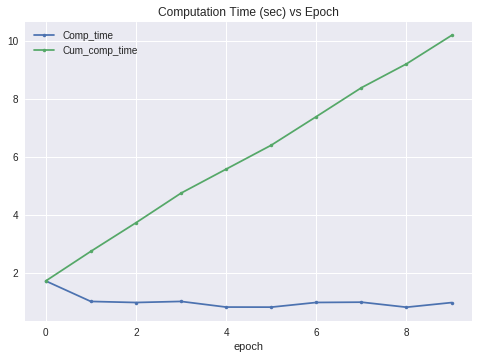

### Model id:  11


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
100,0,relu,64,1.786579,1.786579,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,0.732,0.858844,0.831,0.495334
101,1,relu,64,0.986712,2.773291,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,0.950,0.182935,0.879,0.403503
102,2,relu,64,0.977643,3.750934,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,0.989,0.053650,0.894,0.363851
103,3,relu,64,0.975898,4.726831,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,0.999,0.012089,0.895,0.362931
104,4,relu,64,0.984391,5.711223,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.002268,0.899,0.420691
105,5,relu,64,0.820794,6.532017,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.001235,0.898,0.426240
106,6,relu,64,1.004805,7.536822,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.000735,0.902,0.428067
107,7,relu,64,0.982290,8.519111,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.000518,0.905,0.431823
108,8,relu,64,0.819835,9.338947,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.000475,0.904,0.435303
109,9,relu,64,0.824276,10.163223,0.5,sparse_categorical_crossentropy,Adam,MNIST_1000samples,11,CNN,1.000,0.000422,0.903,0.438259


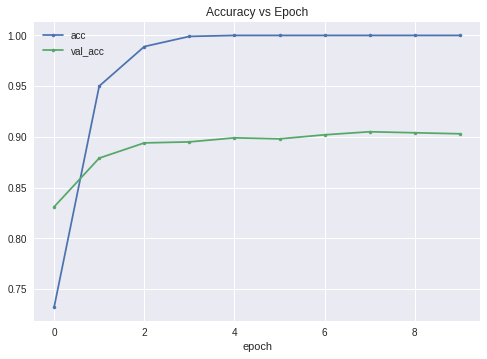

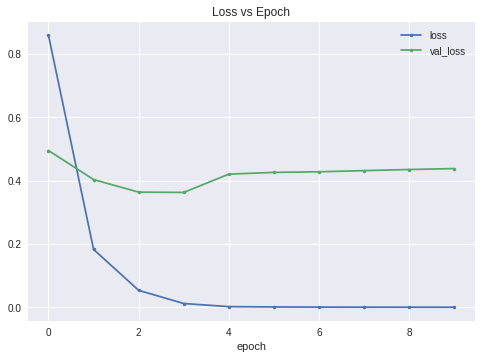

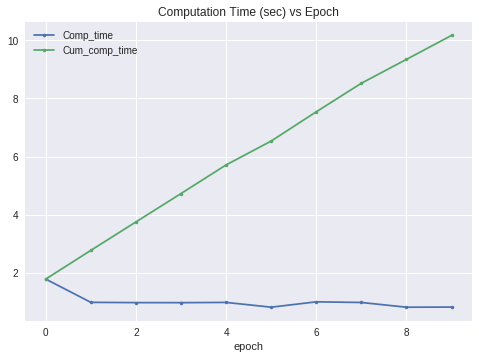

### Model id:  12


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
110,0,relu,64,1.822218,1.822218,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,0.711,0.906433,0.774,0.702889
111,1,relu,64,0.983613,2.805832,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,0.929,0.260159,0.871,0.403244
112,2,relu,64,0.979016,3.784847,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,0.977,0.084528,0.887,0.325858
113,3,relu,64,1.008518,4.793365,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,0.992,0.028354,0.889,0.427714
114,4,relu,64,0.821968,5.615333,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.008359,0.888,0.414746
115,5,relu,64,1.002494,6.617827,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.004356,0.894,0.454462
116,6,relu,64,1.001791,7.619618,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.002380,0.901,0.431532
117,7,relu,64,0.826182,8.445800,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.001306,0.898,0.428510
118,8,relu,64,0.831602,9.277402,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.001385,0.900,0.440390
119,9,relu,64,0.829340,10.106743,0.7,sparse_categorical_crossentropy,Adam,MNIST_1000samples,12,CNN,1.000,0.001050,0.900,0.447953


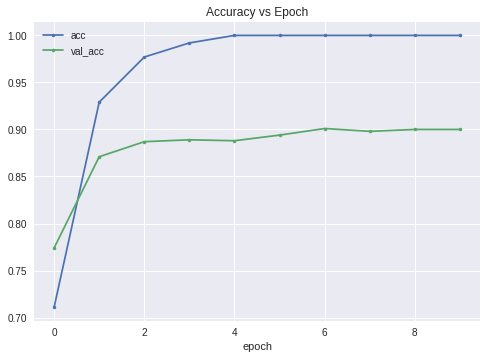

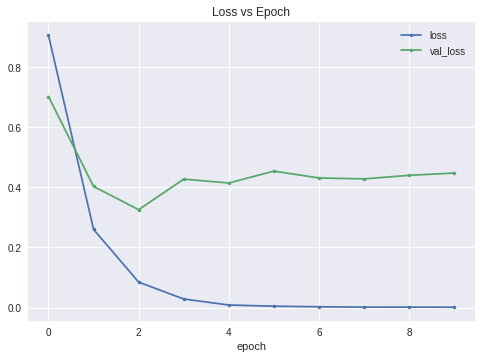

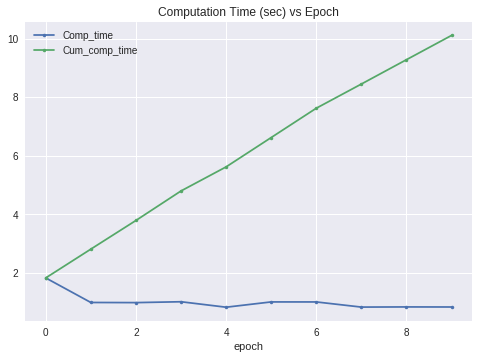

### Model id:  13


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
120,0,relu,64,1.882470,1.882470,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.675,1.060703,0.807,0.597564
121,1,relu,64,1.025696,2.908166,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.881,0.408057,0.840,0.480213
122,2,relu,64,0.983099,3.891265,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.909,0.294026,0.872,0.403049
123,3,relu,64,0.973859,4.865124,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.939,0.212875,0.883,0.389354
124,4,relu,64,0.827147,5.692271,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.943,0.162012,0.883,0.381285
125,5,relu,64,0.986132,6.678403,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.967,0.121319,0.889,0.360313
126,6,relu,64,0.830982,7.509385,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.967,0.089816,0.888,0.376579
127,7,relu,64,0.976983,8.486368,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.974,0.064212,0.893,0.365047
128,8,relu,64,0.979560,9.465928,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.984,0.046452,0.894,0.351720
129,9,relu,64,0.989829,10.455757,0.9,sparse_categorical_crossentropy,Adam,MNIST_1000samples,13,CNN,0.986,0.045909,0.895,0.394205


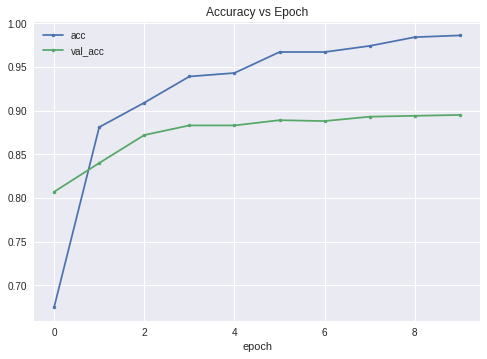

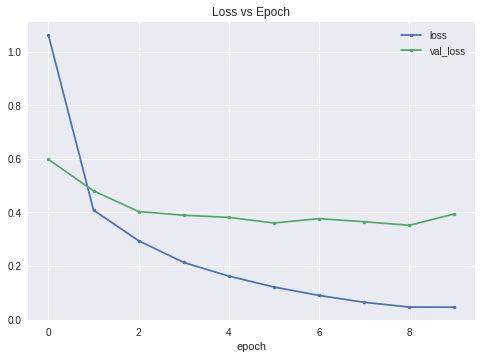

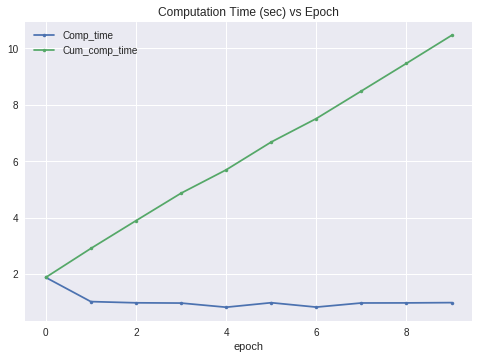

### Model id:  14


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
130,0,relu,64,1.871938,1.871938,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.568,1.956486,0.715,1.624412
131,1,relu,64,0.846070,2.718008,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.814,1.172503,0.770,1.060840
132,2,relu,64,0.815181,3.533188,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.858,0.702980,0.783,0.771106
133,3,relu,64,0.795075,4.328264,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.879,0.491263,0.811,0.629370
134,4,relu,64,0.803179,5.131442,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.893,0.397391,0.830,0.554923
135,5,relu,64,0.798136,5.929578,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.915,0.333135,0.837,0.505121
136,6,relu,64,0.822667,6.752245,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.929,0.290804,0.851,0.478946
137,7,relu,64,0.789446,7.541691,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.943,0.249782,0.857,0.453376
138,8,relu,64,0.641819,8.183511,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.946,0.219998,0.857,0.432120
139,9,relu,64,0.811225,8.994735,0.0,sparse_categorical_crossentropy,Adam_lr0.0001,MNIST_1000samples,14,CNN,0.956,0.197571,0.858,0.426350


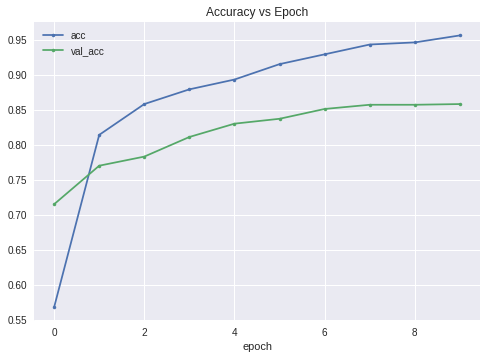

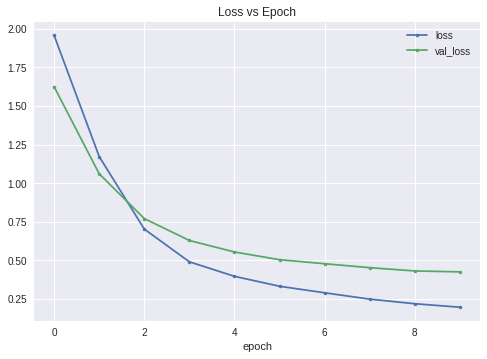

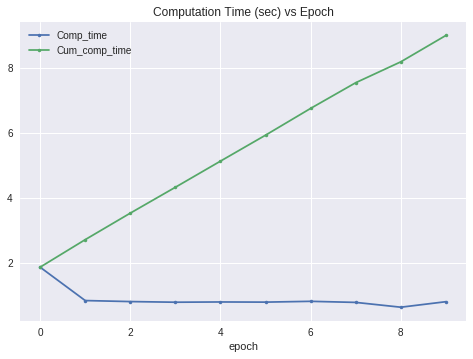

### Model id:  15


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
140,0,relu,64,1.966462,1.966462,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,0.667,1.276026,0.825,0.507437
141,1,relu,64,0.837948,2.804410,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,0.939,0.206934,0.892,0.347957
142,2,relu,64,0.644066,3.448477,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,0.987,0.050289,0.876,0.395928
143,3,relu,64,0.830519,4.278996,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,0.997,0.011314,0.897,0.381139
144,4,relu,64,0.793991,5.072987,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.001406,0.907,0.402652
145,5,relu,64,0.651628,5.724614,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000514,0.907,0.406580
146,6,relu,64,0.800749,6.525363,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000296,0.909,0.421109
147,7,relu,64,0.801052,7.326416,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000216,0.910,0.422897
148,8,relu,64,0.639325,7.965740,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000178,0.910,0.424575
149,9,relu,64,0.635834,8.601574,0.0,sparse_categorical_crossentropy,Adam_lr0.01,MNIST_1000samples,15,CNN,1.000,0.000153,0.910,0.425997


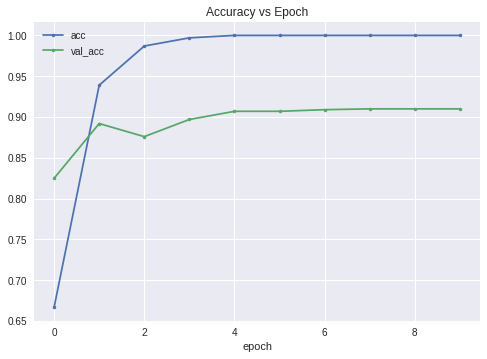

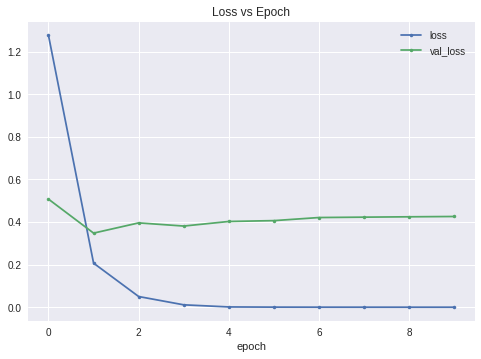

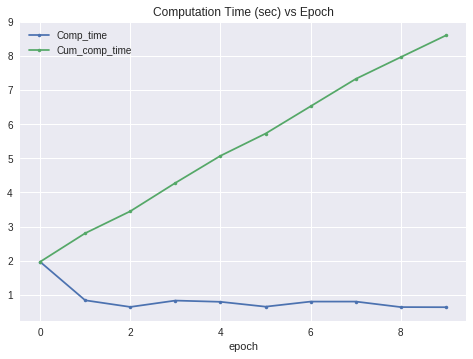

### Model id:  16


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
150,0,relu,64,1.716610,1.716610,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.452,2.231876,0.637,2.156470
151,1,relu,64,0.707395,2.424005,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.715,2.032704,0.651,1.960641
152,2,relu,64,0.710127,3.134132,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.724,1.759112,0.698,1.682695
153,3,relu,64,0.602851,3.736983,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.763,1.419230,0.698,1.382873
154,4,relu,64,0.708341,4.445324,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.795,1.112454,0.744,1.141214
155,5,relu,64,0.610697,5.056021,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.825,0.888587,0.743,0.977426
156,6,relu,64,0.711534,5.767555,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.835,0.749476,0.766,0.868584
157,7,relu,64,0.725631,6.493186,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.846,0.652761,0.773,0.790865
158,8,relu,64,0.728736,7.221923,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.861,0.588456,0.790,0.742589
159,9,relu,64,0.607358,7.829281,0.0,sparse_categorical_crossentropy,SGD,MNIST_1000samples,16,CNN,0.868,0.539909,0.788,0.699701


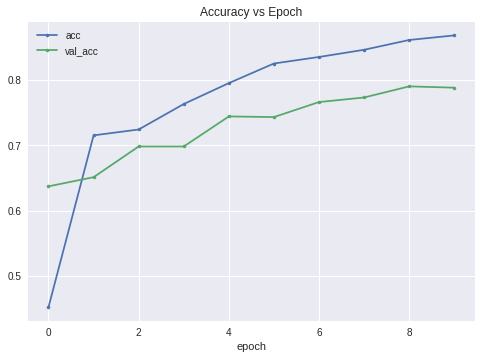

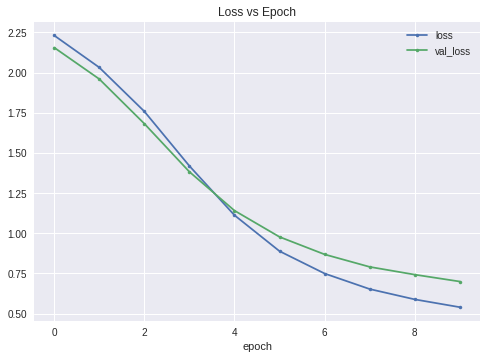

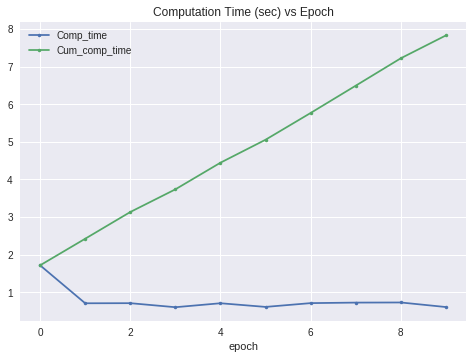

### Model id:  17


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
160,0,relu,64,1.832303,1.832303,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.448,2.171025,0.662,2.000123
161,1,relu,64,0.709239,2.541542,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.729,1.678177,0.684,1.460330
162,2,relu,64,0.731836,3.273378,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.788,1.071101,0.741,1.012731
163,3,relu,64,0.713742,3.987120,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.835,0.736929,0.774,0.808182
164,4,relu,64,0.717668,4.704788,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.851,0.581326,0.795,0.703759
165,5,relu,64,0.714977,5.419765,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.866,0.503161,0.807,0.647163
166,6,relu,64,0.717464,6.137229,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.877,0.452482,0.813,0.604395
167,7,relu,64,0.722557,6.859786,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.886,0.419520,0.825,0.574287
168,8,relu,64,0.592698,7.452484,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.887,0.388042,0.819,0.564769
169,9,relu,64,0.735239,8.187723,0.0,sparse_categorical_crossentropy,SGD_momentum_0.5,MNIST_1000samples,17,CNN,0.899,0.363383,0.844,0.529092


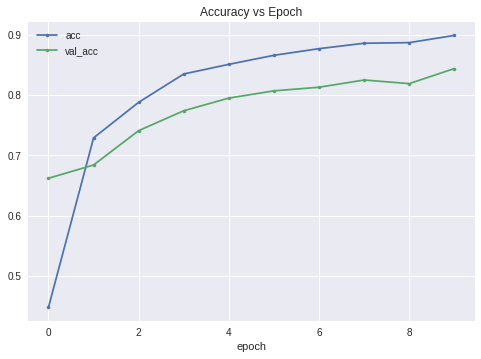

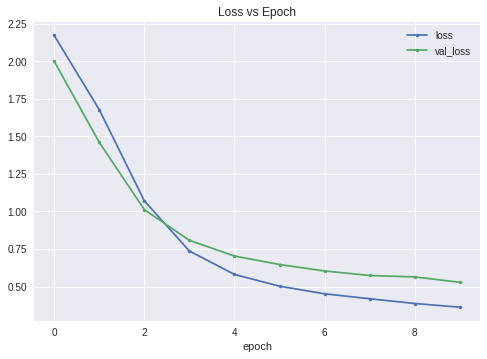

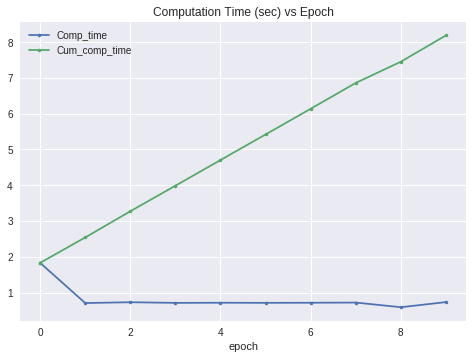

### Model id:  18


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
170,0,relu,64,1.806222,1.806222,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.515,1.974078,0.697,1.301598
171,1,relu,64,0.703568,2.509790,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.813,0.692105,0.768,0.674842
172,2,relu,64,0.724957,3.234747,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.860,0.446623,0.795,0.651461
173,3,relu,64,0.709149,3.943896,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.892,0.364509,0.807,0.612117
174,4,relu,64,0.718050,4.661946,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.893,0.330447,0.834,0.506961
175,5,relu,64,0.722492,5.384438,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.919,0.268995,0.842,0.493477
176,6,relu,64,0.599787,5.984225,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.934,0.228526,0.838,0.526692
177,7,relu,64,0.731243,6.715469,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.937,0.216530,0.844,0.518747
178,8,relu,64,0.610245,7.325714,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.939,0.195923,0.829,0.577088
179,9,relu,64,0.603090,7.928803,0.0,sparse_categorical_crossentropy,SGD_momentum_0.9,MNIST_1000samples,18,CNN,0.937,0.197787,0.835,0.569281


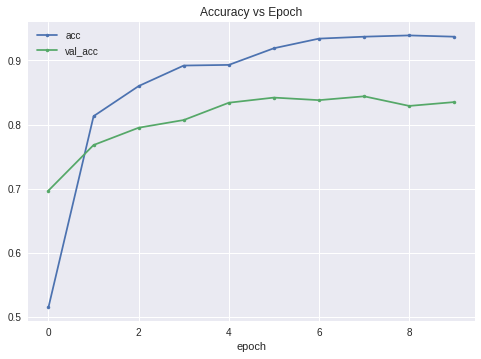

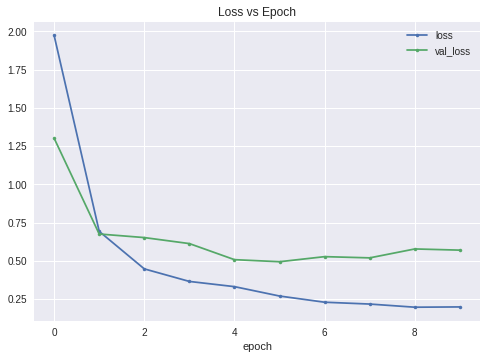

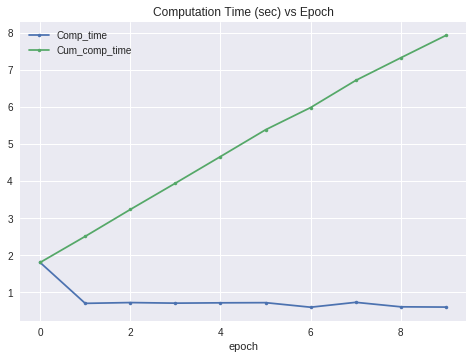

### Model id:  19


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
180,0,relu,64,1.902600,1.902600,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.535,1.850267,0.728,0.937480
181,1,relu,64,0.755669,2.658269,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.818,0.686426,0.786,1.026628
182,2,relu,64,0.721140,3.379409,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.874,0.782807,0.812,1.312290
183,3,relu,64,0.602731,3.982139,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.885,0.700078,0.788,1.521681
184,4,relu,64,0.596241,4.578381,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.911,0.476556,0.800,0.862522
185,5,relu,64,0.611178,5.189559,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.921,0.396350,0.798,0.701189
186,6,relu,64,0.721751,5.911310,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.945,0.241170,0.817,0.747789
187,7,relu,64,0.713535,6.624845,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.955,0.225932,0.823,1.137881
188,8,relu,64,0.728589,7.353434,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.965,0.215676,0.827,1.286480
189,9,relu,64,0.707675,8.061110,0.0,sparse_categorical_crossentropy,SGD_momentum_0.99,MNIST_1000samples,19,CNN,0.979,0.164175,0.834,1.338237


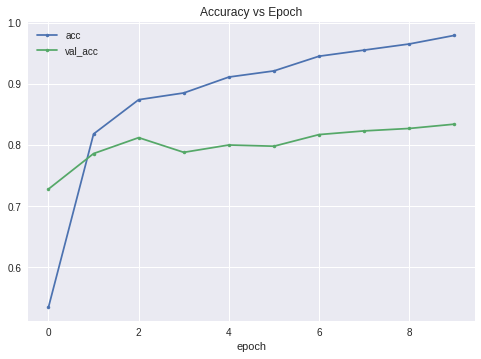

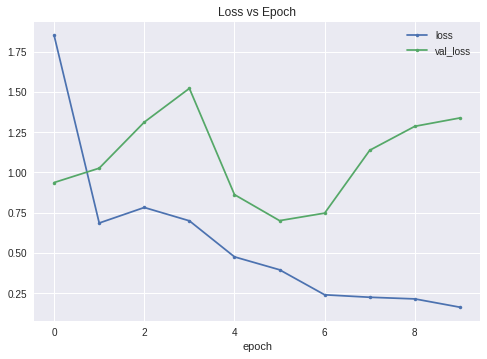

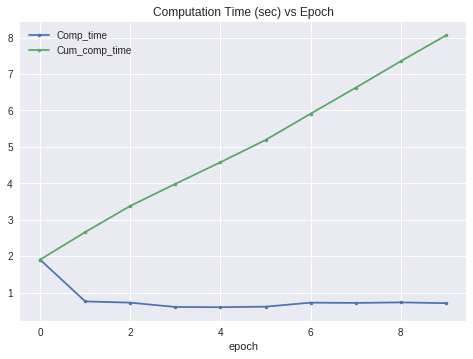

### Model id:  20


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
190,0,relu,64,1.907097,1.907097,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,0.684,1.017668,0.792,0.627154
191,1,relu,64,0.741168,2.648265,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,0.906,0.316797,0.853,0.442921
192,2,relu,64,0.765923,3.414188,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,0.955,0.160722,0.861,0.406720
193,3,relu,64,0.745883,4.160070,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,0.978,0.078261,0.867,0.393592
194,4,relu,64,0.627612,4.787682,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,0.995,0.032488,0.821,0.570625
195,5,relu,64,0.738800,5.526483,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,0.998,0.024046,0.894,0.394155
196,6,relu,64,0.619134,6.145616,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,1.000,0.006412,0.873,0.473575
197,7,relu,64,0.625442,6.771058,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,0.999,0.006700,0.882,0.395972
198,8,relu,64,0.630961,7.402019,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,1.000,0.002796,0.867,0.574633
199,9,relu,64,0.631284,8.033303,0.0,sparse_categorical_crossentropy,RMSprop,MNIST_1000samples,20,CNN,1.000,0.001684,0.883,0.478961


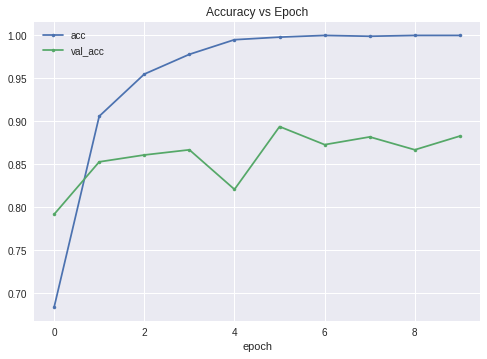

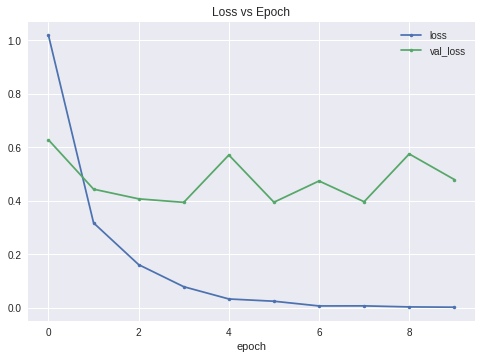

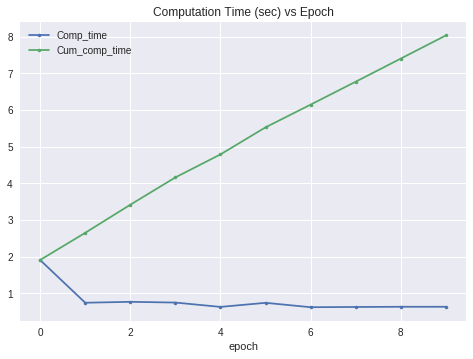

### Model id:  21


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
200,0,relu,64,1.892123,1.892123,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,0.634,1.535319,0.821,0.535315
201,1,relu,64,0.723607,2.615730,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,0.940,0.233353,0.854,0.414409
202,2,relu,64,0.721703,3.337433,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,0.973,0.111290,0.878,0.351555
203,3,relu,64,0.732085,4.069519,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,0.991,0.052939,0.888,0.338733
204,4,relu,64,0.755256,4.824775,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,0.999,0.027438,0.892,0.343486
205,5,relu,64,0.634220,5.458995,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,1.000,0.015853,0.886,0.343271
206,6,relu,64,0.728964,6.187958,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,1.000,0.010898,0.894,0.336661
207,7,relu,64,0.617260,6.805218,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,1.000,0.008129,0.890,0.342038
208,8,relu,64,0.618163,7.423381,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,1.000,0.006278,0.891,0.354936
209,9,relu,64,0.622114,8.045495,0.0,sparse_categorical_crossentropy,Adagrad,MNIST_1000samples,21,CNN,1.000,0.005181,0.893,0.352580


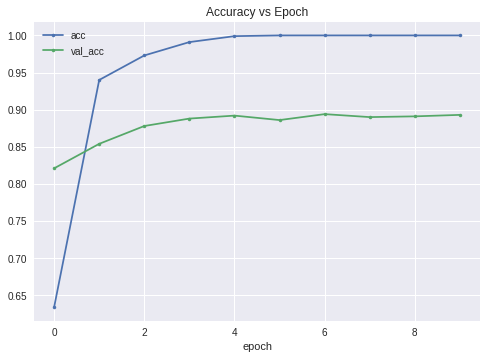

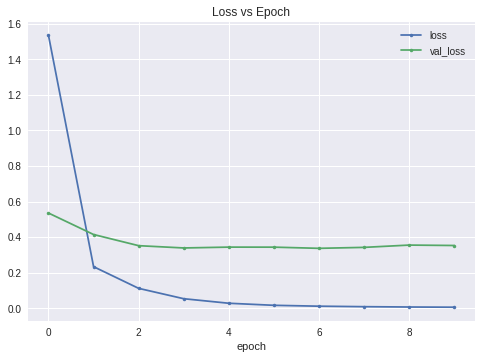

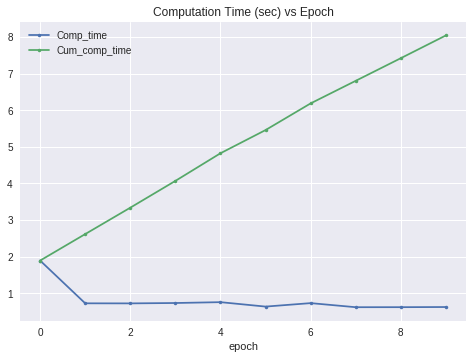

### Model id:  22


,epoch,Acivation,Batch_size,Comp_time,Cum_comp_time,Dropout_rate,Objective,Optimizer,_Dataset_name,_Model_id,_Model_setup,acc,loss,val_acc,val_loss
210,0,relu,64,2.116831,2.116831,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.598,1.255142,0.735,0.805484
211,1,relu,64,0.804554,2.921384,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.862,0.496727,0.812,0.586374
212,2,relu,64,0.801554,3.722938,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.900,0.327724,0.857,0.443754
213,3,relu,64,0.660501,4.383439,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.946,0.198370,0.825,0.556553
214,4,relu,64,0.849096,5.232535,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.965,0.150298,0.858,0.430249
215,5,relu,64,0.837534,6.070069,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.978,0.097154,0.874,0.421782
216,6,relu,64,0.671277,6.741346,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.991,0.056510,0.858,0.480355
217,7,relu,64,0.666551,7.407897,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.995,0.039896,0.847,0.499019
218,8,relu,64,0.828224,8.236121,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,0.998,0.026119,0.878,0.420400
219,9,relu,64,0.662082,8.898203,0.0,sparse_categorical_crossentropy,Adadelta,MNIST_1000samples,22,CNN,1.000,0.013344,0.876,0.435321


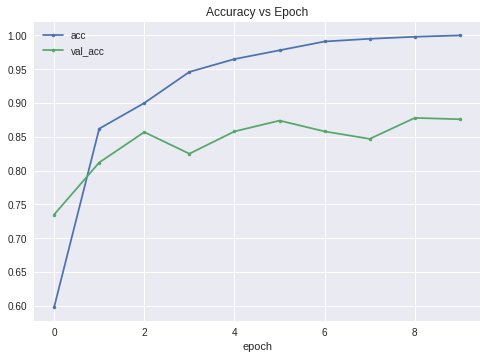

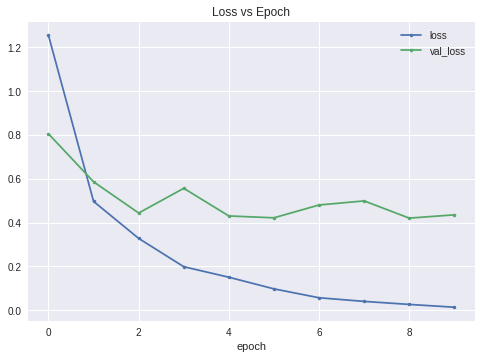

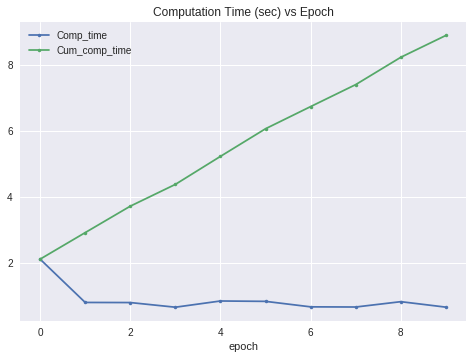

In [8]:
## Plot the results
# pd.options.display.max_rows = 8
lfp.plot_log(show_table=True)


References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

https://keras.io/getting-started/sequential-model-guide/